# Dropout

Welcome to the 6th week of deep learning programming!

So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

In this week you will implement convolutional and max pooling layers in `ex06_conv_layer` and dropout layer in `ex06_dropout_layer`.


Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from utils.fc_net import *
from utils.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [7]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass (5pt)
In the file `utils/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [2]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})
    
    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.3
Mean of input:  10.000207878477502
Mean of train-time output:  10.035072797050494
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.699124
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.000207878477502
Mean of train-time output:  9.976910758765856
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.401368
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.000207878477502
Mean of train-time output:  9.993068588261146
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.250496
Fraction of test-time output set to zero:  0.0



# Dropout backward pass (3pt)
In the file `utils/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [5]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445612718272284e-11


# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout (p=1), and one will use a dropout probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [8]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print(dropout)
    
    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={
                        'learning_rate': 5e-4,
                    },
                    verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

1
(Iteration 1 / 125) loss: 7.856644
(Epoch 0 / 25) train acc: 0.274000; val_acc: 0.192000
(Epoch 1 / 25) train acc: 0.368000; val_acc: 0.238000
(Epoch 2 / 25) train acc: 0.540000; val_acc: 0.239000
(Epoch 3 / 25) train acc: 0.622000; val_acc: 0.250000
(Epoch 4 / 25) train acc: 0.714000; val_acc: 0.266000
(Epoch 5 / 25) train acc: 0.726000; val_acc: 0.284000
(Epoch 6 / 25) train acc: 0.788000; val_acc: 0.269000
(Epoch 7 / 25) train acc: 0.870000; val_acc: 0.284000
(Epoch 8 / 25) train acc: 0.882000; val_acc: 0.279000
(Epoch 9 / 25) train acc: 0.932000; val_acc: 0.297000
(Epoch 10 / 25) train acc: 0.896000; val_acc: 0.300000
(Epoch 11 / 25) train acc: 0.928000; val_acc: 0.285000
(Epoch 12 / 25) train acc: 0.920000; val_acc: 0.253000
(Epoch 13 / 25) train acc: 0.948000; val_acc: 0.280000
(Epoch 14 / 25) train acc: 0.980000; val_acc: 0.309000
(Epoch 15 / 25) train acc: 0.962000; val_acc: 0.315000
(Epoch 16 / 25) train acc: 0.978000; val_acc: 0.297000
(Epoch 17 / 25) train acc: 0.968000; v

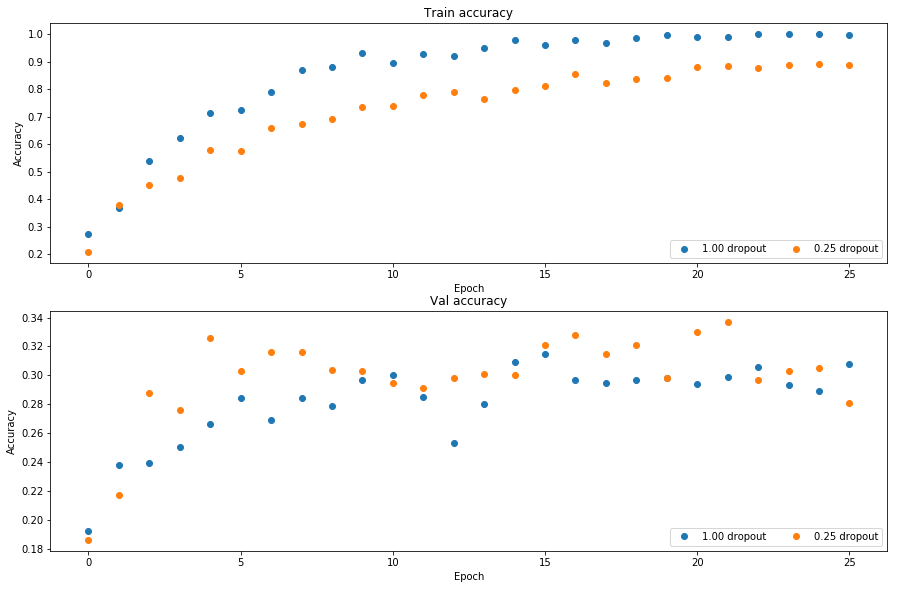

In [9]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question (3pt)
Explain what you see in this experiment. What does it suggest about dropout?

# Answer


Write your answer here!